In [ ]:
# configration of path of kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c playground-series-s4e9

playground-series-s4e9.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from zipfile import ZipFile
dataset='/content/playground-series-s4e9.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('Successfully File Extracted')

Successfully File Extracted


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv('/content/train.csv')
data.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [ ]:
data.drop(columns=['id'],inplace=True)

In [ ]:
data.shape

(188533, 12)

In [ ]:
data.isnull().sum()

brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

In [ ]:
dict(data.fuel_type.value_counts())

{'Gasoline': 165940,
 'Hybrid': 6832,
 'E85 Flex Fuel': 5406,
 'Diesel': 3955,
 '–': 781,
 'Plug-In Hybrid': 521,
 'not supported': 15}

In [ ]:
data.drop(index=data [ data.fuel_type == '–' ].index,inplace=True)
data.drop(index=data [ data.fuel_type == 'not supported' ].index,inplace=True)

In [ ]:
import re

In [ ]:
from typing_extensions import dataclass_transform
# data cleaning

def Cleaning(data):
  data['color_match'] = data.apply( lambda row : 1 if row['ext_col']== row['int_col'] else 0, axis=1)
  data['clean_title'].fillna('No',inplace=True)
  data['turbo'] = data['engine'].apply(lambda x: 1 if 'turbo' in x.lower() else 0)

  # clean data transmission
  data['transmission'] = data['transmission'].apply(data_transform)

  # extract engine data
  engine_info = data['engine'].apply(extract_engine_info)
  data['engine_hp'] = engine_info.apply(lambda x: x['hp'])
  data['engine_liter'] = engine_info.apply(lambda x: x['liter'])
  data['engine_cylinder'] = engine_info.apply(lambda x: x['cylinder'])

  #clean another data
  luxury_brand = ['Mercedes-Benz', 'BMW', 'Audi', 'Porsche', 'Land',
                    'Lexus', 'Jaguar', 'Bentley', 'Maserati', 'Lamborghini',
                    'Rolls-Royce', 'Ferrari', 'McLaren', 'Aston', 'Maybach']
  data['luxury_brand'] = data.brand.apply(lambda x: 1 if x in luxury_brand else 0)
  data['extracted_fuel_type'] = data.engine.apply(extracted_fuel_type)
  data['car_age'] = 2024 - data.model_year
  data['milage_per_year'] = (data.milage / data.car_age)
  data['Power_to_Weight_Ratio'] = (data['engine_hp'] / data['engine_liter'])
  return data

def extract_engine_info(text):
  result = {'hp': None, 'liter': None, 'cylinder': None}

  hp = re.search(r'(\d+(\.\d+)?)HP', text)
  if hp:
      result['hp'] = float(hp.group(1))

  liter = re.search(r'(\d+(\.\d+)?)L', text)
  if liter:
      result['liter'] = float(liter.group(1))

  cylinder = re.search(r'(\d+) Cylinder|V(\d+)', text, re.IGNORECASE)
  if cylinder:
      result['cylinder'] = int(cylinder.group(1) or cylinder.group(2))

  return result

def extracted_fuel_type(engine_info):
  if pd.isna(engine_info):
      return np.nan
  if 'Gasoline' in engine_info:
      return 'Gasoline'
  elif 'Hybrid' in engine_info:
      return 'Hybrid'
  elif 'Flex Fuel' in engine_info or 'E85' in engine_info:
      return 'Flex Fuel'
  elif 'Diesel' in engine_info:
      return 'Diesel'
  elif 'Electric' in engine_info:
      return 'Electric'
  else:
      return np.nan

def data_transform(info):
  if re.search(r'\b(Automatic|A/T|AT|Dual Shift Mode|CVT)\b', info, re.IGNORECASE):
      return 'AT'
  elif re.search(r'\b(Manual|M/T|MT)\b', info, re.IGNORECASE):
      return 'MT'
  else:
      return info

In [ ]:
cln_data = Cleaning(data)

In [ ]:
cln_data.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,color_match,turbo,engine_hp,engine_liter,engine_cylinder,luxury_brand,extracted_fuel_type,car_age,milage_per_year,Power_to_Weight_Ratio
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,AT,Yellow,Gray,None reported,...,0,0,172.0,1.6,4.0,0,Gasoline,17,12529.411765,107.500000
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,AT,Silver,Beige,At least 1 accident or damage reported,...,0,0,252.0,3.9,8.0,0,Gasoline,22,6511.363636,64.615385
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,AT,Blue,Gray,None reported,...,0,0,320.0,5.3,8.0,0,Flex Fuel,22,6215.045455,60.377358
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,AT,Black,Black,None reported,...,1,0,420.0,5.0,8.0,0,Gasoline,7,2785.714286,84.000000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,AT,Black,Beige,None reported,...,0,0,208.0,2.0,4.0,1,Gasoline,3,2462.666667,104.000000


In [ ]:
cln_data.isnull().sum()

brand                        0
model                        0
model_year                   0
milage                       0
fuel_type                 5083
engine                       0
transmission                 0
ext_col                      0
int_col                      0
accident                  2435
clean_title                  0
price                        0
color_match                  0
turbo                        0
engine_hp                32485
engine_liter             13435
engine_cylinder          20984
luxury_brand                 0
extracted_fuel_type      30772
car_age                      0
milage_per_year              0
Power_to_Weight_Ratio    37106
dtype: int64

In [ ]:
cln_data.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price', 'color_match', 'turbo', 'engine_hp', 'engine_liter',
       'engine_cylinder', 'luxury_brand', 'extracted_fuel_type', 'car_age',
       'milage_per_year', 'Power_to_Weight_Ratio'],
      dtype='object')

In [ ]:
cln_data.fuel_type.fillna(data.extracted_fuel_type,inplace=True)

In [ ]:
cln_data.drop(columns=['brand', 'model', 'model_year', 'milage','engine','ext_col', 'int_col', 'extracted_fuel_type'],inplace=True)

In [ ]:
cln_data.head()

,fuel_type,transmission,accident,clean_title,price,color_match,turbo,engine_hp,engine_liter,engine_cylinder,luxury_brand,car_age,milage_per_year,Power_to_Weight_Ratio
0,Gasoline,AT,None reported,Yes,4200,0,0,172.0,1.6,4.0,0,17,12529.411765,107.500000
1,Gasoline,AT,At least 1 accident or damage reported,Yes,4999,0,0,252.0,3.9,8.0,0,22,6511.363636,64.615385
2,E85 Flex Fuel,AT,None reported,Yes,13900,0,0,320.0,5.3,8.0,0,22,6215.045455,60.377358
3,Gasoline,AT,None reported,Yes,45000,1,0,420.0,5.0,8.0,0,7,2785.714286,84.000000
4,Gasoline,AT,None reported,Yes,97500,0,0,208.0,2.0,4.0,1,3,2462.666667,104.000000


In [ ]:
from sklearn.preprocessing import LabelEncoder,StandardScaler

In [ ]:
encode = LabelEncoder()
cln_data.fuel_type = encode.fit_transform(cln_data.fuel_type)
cln_data.transmission = encode.fit_transform(cln_data.transmission)
cln_data.accident	 = encode.fit_transform(cln_data.accident	)
cln_data.clean_title	 = encode.fit_transform(cln_data.clean_title	)

In [ ]:
cln_data.head()

,fuel_type,transmission,accident,clean_title,price,color_match,turbo,engine_hp,engine_liter,engine_cylinder,luxury_brand,car_age,milage_per_year,Power_to_Weight_Ratio
0,4,3,1,1,4200,0,0,172.0,1.6,4.0,0,17,12529.411765,107.500000
1,4,3,0,1,4999,0,0,252.0,3.9,8.0,0,22,6511.363636,64.615385
2,1,3,1,1,13900,0,0,320.0,5.3,8.0,0,22,6215.045455,60.377358
3,4,3,1,1,45000,1,0,420.0,5.0,8.0,0,7,2785.714286,84.000000
4,4,3,1,1,97500,0,0,208.0,2.0,4.0,1,3,2462.666667,104.000000


In [ ]:
cln_data.describe()

,fuel_type,transmission,accident,clean_title,price,color_match,turbo,engine_hp,engine_liter,engine_cylinder,luxury_brand,car_age,milage_per_year,Power_to_Weight_Ratio
count,187737.000000,187737.000000,187737.000000,187737.000000,1.877370e+05,187737.000000,187737.000000,155252.000000,174302.000000,166753.000000,187737.000000,187737.000000,1.877370e+05,150631.000000
mean,3.822374,3.180748,0.793104,0.886048,4.391092e+04,0.218763,0.076011,343.274302,3.806665,6.445317,0.433553,8.126049,inf,93.462054
std,0.851041,0.610912,0.435926,0.317754,7.855102e+04,0.413409,0.265016,114.730125,1.355913,1.550093,0.495566,5.586181,NaN,27.279915
min,0.000000,0.000000,0.000000,0.000000,2.000000e+03,0.000000,0.000000,70.000000,0.650000,3.000000,0.000000,0.000000,5.263158e+00,27.692308
25%,4.000000,3.000000,1.000000,1.000000,1.700000e+04,0.000000,0.000000,263.000000,3.000000,6.000000,0.000000,4.000000,5.181818e+03,70.000000
50%,4.000000,3.000000,1.000000,1.000000,3.090000e+04,0.000000,0.000000,329.000000,3.500000,6.000000,0.000000,7.000000,8.000000e+03,87.428571
75%,4.000000,3.000000,1.000000,1.000000,4.990000e+04,0.000000,0.000000,416.000000,4.800000,8.000000,1.000000,11.000000,1.100000e+04,113.333333
max,7.000000,10.000000,2.000000,1.000000,2.954083e+06,1.000000,1.000000,1020.000000,8.400000,12.000000,1.000000,50.000000,inf,261.538462


In [ ]:
cln_data.drop(index=cln_data[cln_data.milage_per_year == float('inf')].index,inplace=True)
cln_data.dropna(inplace=True)

In [ ]:
X = cln_data.drop(columns=['price']).values
y = cln_data.price.values

In [ ]:
scal = StandardScaler()
scal.fit(X)
std_X = scal.transform(X)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
Model = DecisionTreeRegressor()
Model.fit(X,y)


DecisionTreeRegressor()

In [ ]:
y_pre = Model.predict(X)

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
error = np.sqrt(mean_squared_error(y,y_pre))

In [ ]:
# error on training data
error

17407.621607888224

In [ ]:
test_data = pd.read_csv('/content/test.csv')
test_data.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


In [ ]:
cln_tst  = Cleaning(test_data)

In [ ]:
cln_tst.fuel_type.fillna(cln_tst.extracted_fuel_type,inplace=True)

In [ ]:
cln_tst.accident.value_counts()

accident
None reported                             96263
At least 1 accident or damage reported    27795
Name: count, dtype: int64

In [ ]:
cln_tst.isnull().sum()

id                           0
brand                        0
model                        0
model_year                   0
milage                       0
fuel_type                  111
engine                       0
transmission                 0
ext_col                      0
int_col                      0
accident                  1632
clean_title                  0
color_match                  0
turbo                        0
engine_hp                22181
engine_liter              9407
engine_cylinder          14529
luxury_brand                 0
extracted_fuel_type      21015
car_age                      0
milage_per_year              0
Power_to_Weight_Ratio    25185
dtype: int64

<Axes: ylabel='Density'>

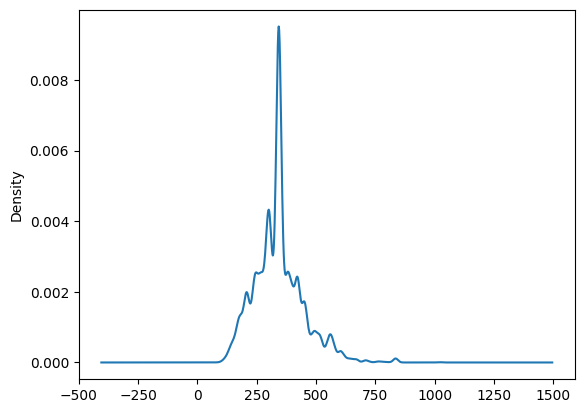

In [ ]:
cln_tst.engine_hp.plot(kind='kde')

<Axes: ylabel='Density'>

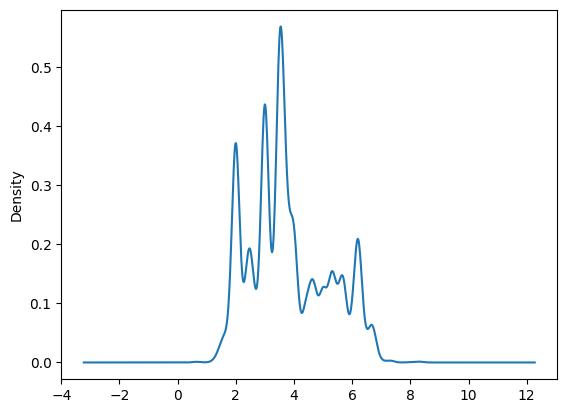

In [ ]:
cln_tst.engine_liter.plot(kind='kde')

<Axes: ylabel='Density'>

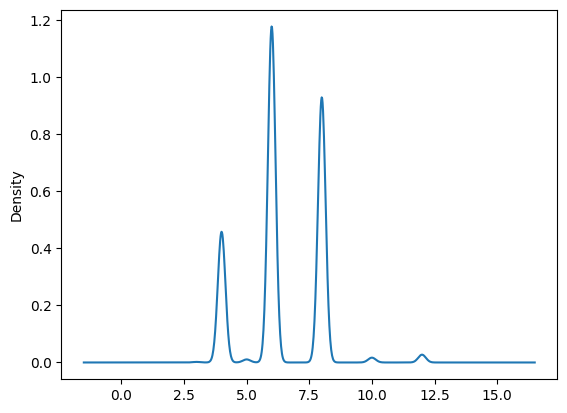

In [ ]:
cln_tst.engine_cylinder.plot(kind='kde')

<Axes: ylabel='Density'>

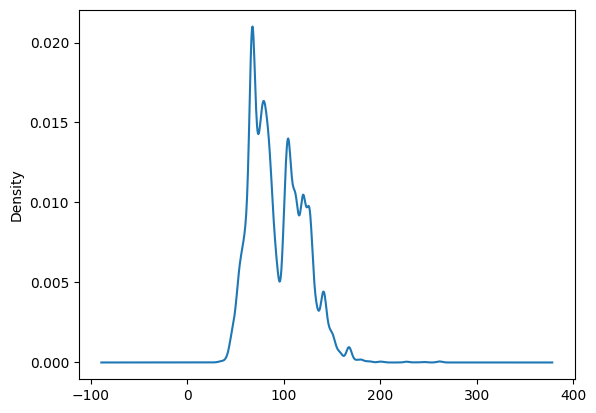

In [ ]:

cln_tst.Power_to_Weight_Ratio.plot(kind='kde')

In [ ]:
mn = cln_tst.drop(index=cln_tst[cln_tst.milage_per_year == float('inf')].index).milage_per_year.max()
def milage(x):
  if x == float('inf'):
    return mn
  return x

cln_tst.milage_per_year = cln_tst.milage_per_year.apply(milage)

cln_tst.fuel_type.fillna('Electric',inplace=True)
cln_tst.accident.fillna('None reported',inplace=True)
cln_tst.engine_hp.fillna(cln_tst.engine_hp.mean(),inplace=True)
cln_tst.engine_liter.fillna(cln_tst.engine_liter.mean(),inplace=True)
cln_tst.engine_cylinder.fillna(cln_tst.engine_cylinder.mean(),inplace=True)
cln_tst.Power_to_Weight_Ratio.fillna(cln_tst.Power_to_Weight_Ratio.mean(),inplace=True)

In [ ]:
cln_tst.isnull().sum()

id                           0
brand                        0
model                        0
model_year                   0
milage                       0
fuel_type                    0
engine                       0
transmission                 0
ext_col                      0
int_col                      0
accident                     0
clean_title                  0
color_match                  0
turbo                        0
engine_hp                    0
engine_liter                 0
engine_cylinder              0
luxury_brand                 0
extracted_fuel_type      21015
car_age                      0
milage_per_year              0
Power_to_Weight_Ratio        0
dtype: int64

In [ ]:
cln_tst.drop(columns=['brand', 'model', 'model_year', 'milage','engine','ext_col', 'int_col', 'extracted_fuel_type'],inplace=True)

In [ ]:
encode = LabelEncoder()
cln_tst.fuel_type = encode.fit_transform(cln_tst.fuel_type)
cln_tst.transmission = encode.fit_transform(cln_tst.transmission)
cln_tst.accident	 = encode.fit_transform(cln_tst.accident	)
cln_tst.clean_title	 = encode.fit_transform(cln_tst.clean_title	)

In [ ]:
cln_tst.milage_per_year.describe()

count    125690.000000
mean       8860.573548
std        8581.573522
min           2.300000
25%        5179.977273
50%        8000.000000
75%       11000.000000
max      199750.000000
Name: milage_per_year, dtype: float64

In [ ]:
y_pred = Model.predict(cln_tst.drop(columns=['id']).values)

In [ ]:
submission = pd.DataFrame({
    'id': cln_tst['id'],
    'price': y_pred })

In [ ]:
submission.to_csv('submission.csv', index=False)